In [1]:
# create Road distance rasters

In [36]:
%load_ext chime
import rasterio as rio
from rasterio.mask import mask
import geopandas as gpd
from shapely.ops import substring
from time import sleep
import numpy as np
from scipy.ndimage import distance_transform_edt
import os
from glob import glob
from datetime import datetime
from shapely.geometry import box
import chime
from joblib import Parallel, delayed
from rasterio.mask import raster_geometry_mask
from math import ceil, floor
import nbimporter
from KeyFunctions import *
import gdal

roadDistance_dir = "../EPCExtent_30cm/RoadDistances"
os.makedirs(roadDistance_dir, exist_ok=True)
orthoseg_loc = os.path.abspath("../EPCExtent_30cm/Orthos_Segmented")
orthos = [os.path.abspath(f) for f in glob("../EPCExtent_30cm/Orthos/*.tif")]
ortho15cmvrt_loc = r"D:/20191212_AZ_PIMA/2019_UrbanExtent_15cm/UGT_15cmOrtho_2019.vrt"
ortho30cmvrt_loc = os.path.abspath("../EPCExtent_30cm/Orthos/EPC_30cmOrtho_2019.vrt")
hagvrt_loc = os.path.abspath("../EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt")

tileindex = gpd.read_file("../EPCExtent_30cm/Orthos/2019_LULC_EPCExtent_30cm_index.shp")
tifsfootprint = tileindex.geometry.unary_union

asphaultPoly_loc = "../OtherData/TrainingData/asphaultPoly.gpkg"
osm_paved = "../OtherData/OSMRoadsPimaPaved_20201124.gpkg"
print(f"Reading in {asphaultPoly_loc}...")
road_targets = gpd.read_file(osm_paved)
bad_roads = ["path", "residential", "cycleway", "service","footway","pedestrian","living_street","steps","unknown","bridleway", "unclassified"]


boxesdf_loc = "../EPCExtent_30cm/Ortho_5kSubIndex.gpkg"
ruralRegions_loc = r"../OtherData/TrainingData/DesertBarrenVegetation_2015.gpkg"
hag_tindex_loc = "../EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_tindex.gpkg"

boxesdf = gpd.read_file(boxesdf_loc)
boxesdf.filepath = boxesdf.filepath.apply(lambda fp: fp.replace("/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmented", "../EPCExtent_30cm/Orthos_Segmentedv2"))
boxesdf["geometry"] = boxesdf["geometry"].apply(lambda g: box(*g.buffer(-50).bounds))

hag_tindex = gpd.read_file(hag_tindex_loc)
rural_regions = gpd.read_file(ruralRegions_loc)

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


The chime extension is already loaded. To reload it, use:
  %reload_ext chime
Reading in ../OtherData/TrainingData/asphaultPoly.gpkg...


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


In [48]:
def done():
    chime.theme("zelda")
    %chime
    chime.theme("material")


def getCommonLandcover(street, writeRasters=False):
    index = street.name
    
    if index % 5000 == 0:
        print(f"On {index} @ {datetime.now()}")
    
    length = street.geometry.length
    substrings = []
    if length > splitlength:
        for i in range(0, ceil(length), splitlength):
            start = i
            end = i + splitlength if i+splitlength < length else length
            substrings.append(substring(street.geometry, start, end))
    else:
        substrings.append(street.geometry)
        
    try:
        commonCovers = []

        for i, string in enumerate(substrings):
            stringPoly = string.buffer(5)

            with rio.open(landcover) as src:
                kwargs = src.profile
                segMask, segTransform, segWindow = raster_geometry_mask(src, [stringPoly], all_touched=True, crop=True, pad=True)
                landcoverData = src.read(1, window=segWindow)
                landcoverData[segMask] = src.nodata
                maskedData = landcoverData[~segMask]
                validValues = maskedData[maskedData!=src.nodata] # for segments that run outside of extent of landcover there may be nodata value on the segement
                unique, frequency = np.unique(validValues, return_counts = True)
                mostCommon = unique[np.argwhere(frequency.max() == frequency)][0][0]
                
                commonCovers.append(coverLookup[mostCommon])
            if writeRasters:
                os.makedirs("./temp", exist_ok=True)
                oras = os.path.join("./temp", str(street.PC_UID) + f"_{i}.tif")
                kwargs.update(transform=segTransform, driver="GTIFF", width=landcoverData.shape[1], height=landcoverData.shape[0])
                with rio.open(oras, 'w', **kwargs) as dst:
                    dst.write(landcoverData, 1)

        return ",".join(set(commonCovers))
    except ValueError:
        #print(f"Index {index} out of coverage")
        return None     


def createDistanceRaster(geom, rasterpath, odir, overwrite=False, buffer_size=10):
    try:
        ofile = os.path.join(odir, os.path.basename(rasterpath).replace(".tif","_dist.tif"))
        if os.path.exists(ofile) and not overwrite:
            return ofile
        
        geom = geom.buffer(buffer_size)
        
        if "Multi" not in geom.type:
            geom = [geom]
        with rio.open(rasterpath) as src:
            kwargs = src.profile
            reso = src.res[0]
            ds, ds_trans = mask(src, geom, all_touched=False, crop=False, filled=False)
        
        distance = distance_transform_edt(ds.mask[0]) * reso

        kwargs.update(count=1,dtype=np.uint16, compress="LZW")


        with rio.open(ofile, "w", **kwargs) as dst:
            dst.write(distance.astype(np.uint16), 1)

        print(f"Finished {ofile} - {datetime.now()}")
        return ofile
    except:
        print(f"FAILED FOR {os.path.basename(ofile)}")
        return None

In [57]:
%%time
road_targets_over = gpd.overlay(road_targets, boxesdf, how="union")

road_targets_diss = road_targets_over.dissolve(by="filepath", as_index=False)

#buffer by 10 so that anything 10 and under is 0 distance
roadFiles = Parallel(n_jobs=6, verbose=5)(delayed(createDistanceRaster)(row.geometry, row.filepath, roadDistance_dir, overwrite=True, buffer_size=10) for i, row in road_targets_diss.iterrows())
roadFiles = [f for f in roadFiles if f is not None]
finished()

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   15.1s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed: 32.0min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed: 41.0min
[Parallel(n_jobs=6)]: Done 1446 tasks      | elapsed: 49.2min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 59.5min
[Parallel(n_jobs=6)]: Done 2166 tasks      | elapsed: 73.7min
[Parallel(n_jobs=6)]: Done 2580 tasks      | elapsed: 89.9min
[Parallel(n_jobs=6)]: Done 3030 tasks      | elapsed: 109.1min


Wall time: 1h 56min 27s


[Parallel(n_jobs=6)]: Done 3189 out of 3189 | elapsed: 115.9min finished


In [56]:
for i, row in road_targets_diss.iterrows():
    if row.path == "W974789" and row.row == "W464850":
        print("Found")
        createDistanceRaster(row.geometry, row.filepath, roadDistance_dir, overwrite=True, buffer_size=10)

Found
Finished ../EPCExtent_30cm/RoadDistances\W974789_W464850_Segmented_dist.tif - 2021-05-05 10:55:18.750291


In [39]:
vrt_file = os.path.join(roadDistance_dir, "EPCRoadDistance_2019.vrt")
vrt = gdal.BuildVRT(vrt_file, roadFiles)
del vrt
print(f"Created {vrt_file}")
done()

Created ../EPCExtent_30cm/RoadDistances\EPCRoadDistance_2019.vrt


In [40]:
road_targets = gpd.read_file(osm_paved)
print(road_targets.highway.unique())
#bad_roads = ["path", "cycleway", "service","footway","pedestrian","living_street","steps","unknown","bridleway", "unclassified"]
#print(road_targets.shape)
#road_targets = road_targets[~road_targets.highway.isin(bad_roads)]
print(road_targets.shape)

['motorway' 'secondary' 'residential' 'track' 'service' 'motorway_link'
 'unclassified' 'road' 'tertiary' 'trunk_link' 'secondary_link' 'trunk'
 'primary' 'primary_link' 'tertiary_link']
(59444, 36)


In [44]:
splitlength = 5000
coverLookup = {1:"water", 2:"trees/shrubs", 3:"irrigated land", 4: "desert", 5:"barren", 6:"impervious", 7:"structure", 8:"road"}
landcover = r"C:\Users\BenJames\Documents\PAG-Data\DirtRoads\pima_landcover_noroads\pima_landcover_noroads.img"


road_targets["Landcover"] = road_targets.apply(lambda r: getCommonLandcover(r), axis=1)
for h in road_targets.highway.unique():
    print(road_targets[road_targets.highway == h].Landcover.unique())

road_targets.to_file("road_targets_Landcover.gpkg", driver="GPKG")
print("FINISHED")
done()

On 0 @ 2021-05-05 09:45:58.340098
On 5000 @ 2021-05-05 09:51:10.865128
On 10000 @ 2021-05-05 09:55:29.977270
On 15000 @ 2021-05-05 09:59:57.522480
On 20000 @ 2021-05-05 10:04:32.235727
On 25000 @ 2021-05-05 10:08:46.671008
On 30000 @ 2021-05-05 10:13:08.154674
On 35000 @ 2021-05-05 10:17:19.132225
On 40000 @ 2021-05-05 10:21:32.479429
On 45000 @ 2021-05-05 10:25:46.396720
On 50000 @ 2021-05-05 10:30:01.242720
On 55000 @ 2021-05-05 10:34:19.352623
['impervious' 'trees/shrubs' 'desert']
['impervious' 'road,impervious' 'barren' 'desert' 'desert,impervious'
 'road' 'barren,impervious' 'structure' 'desert,barren' 'irrigated land'
 'trees/shrubs']
['barren' 'impervious' 'desert' 'desert,barren' 'road'
 'desert,trees/shrubs' None 'trees/shrubs' 'road,desert'
 'barren,impervious' 'irrigated land' 'trees/shrubs,barren'
 'desert,impervious' 'desert,irrigated land,barren'
 'irrigated land,barren' 'desert,barren,impervious' 'road,barren'
 'structure' 'water,barren' 'road,desert,barren' 'road,imper

In [ ]:
#possibly_not_impervious = ["residential", "service", "track", "unclassified"]
#road_targets["Landcover"] = "impervious"
#road_targets["Landcover"] = road_targets.apply(lambda r: getCommonLandcover(r) if r.highway in possibly_not_impervious else "impervious", axis=1)

In [27]:
%load_ext chime
import rasterio as rio
from rasterio.windows import from_bounds, transform
import geopandas as gpd
import pandas as pd
import numpy as np

lulc_2015_loc ="/media/ben/56A08937A0891E9D/Users/BenJames/Documents/PAG-Data/DirtRoads/pima_landcover_noroads/pima_landcover_noroads.img"

boxesdf_loc = "../EPCExtent_30cm/Ortho_5kSubIndex.gpkg"
boxesdf = gpd.read_file(boxesdf_loc)

#tarWin = boxesdf[(boxesdf.path == "W999789") & (boxesdf.row=="W454850")].geometry.values[0]
#bnds = tarWin.bounds
#print(bnds)

values_2015 = {1: "Water", 2:"Trees/Shrubs", 3:"Irrigated" , 4:"Desert", 5:"Barren", 6:"Impervious", 7:"Structure", 8:"Road"}

def getLocal2015Values(row):
    
    bnds = row.geometry.bounds

    with rio.open(lulc_2015_loc) as src:
        twin = from_bounds(bnds[0], bnds[1], bnds[2], bnds[3], transform=src.transform)
        wtrans = transform(twin, src.transform)
        nd = src.nodata
        window_array = src.read(1, window=twin)

        values, counts = np.unique(window_array, return_counts=True)
        total = counts.sum()
        vcs = dict(zip(values, counts))
        
        local_ratios_2015 = {}
        for v in value_cols:
            local_ratios_2015[v] = 0
            
        for k,v in vcs.items():
            if k == 255:
                continue
            local_ratios_2015[values_2015[k]] = v/total
                
        values = [local_ratios_2015[v] for v in value_cols]
        
        return pd.Series(values)

The chime extension is already loaded. To reload it, use:
  %reload_ext chime


In [28]:
value_cols = [v for k, v in values_2015.items()]
boxesdf[value_cols] = boxesdf.apply(lambda r: getLocal2015Values(r), axis=1)
#t = boxesdf[(boxesdf.path == "W999789") & (boxesdf.row=="W454850")].copy()
#t[value_cols] = t.apply(lambda r: getLocal2015Values(r), axis=1)
#t.head()
%chime

In [114]:
values_2019 = {1: "PondLake", 2: "Pool", 3:"Barren", 4:"SparseVeg", 5:"DenseVeg", 6:"Irrigated", 7:"Asphault", 8:"Impervious", 9:"Structure"}


In [29]:
boxesdf.head()

,path,row,filepath,geometry,Water,Trees/Shrubs,Irrigated,Desert,Barren,Impervious,Structure,Road
0,W779839,W284850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 279750.201, 784889.592 28...",0.0,0.001607,0.0,0.002759,0.000795,0.0,0.0,0.000023
1,W779839,W289850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 284750.201, 784889.592 28...",0.0,0.001548,0.0,0.008040,0.001018,0.0,0.0,0.000000
2,W779839,W294850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 289750.201, 784889.592 29...",0.0,0.000739,0.0,0.013970,0.001354,0.0,0.0,0.000000
3,W779839,W299850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 294750.201, 784889.592 29...",0.0,0.000384,0.0,0.019929,0.001036,0.0,0.0,0.000134
4,W779839,W304850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 299750.201, 784889.592 30...",0.0,0.001062,0.0,0.023715,0.002123,0.0,0.0,0.000000


<BarContainer object of 5 artists>

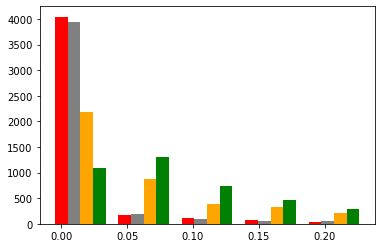

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
struc_heights, struc_bins = np.histogram(boxesdf["Structure"], bins=5)
imp_heights, imp_bins = np.histogram(boxesdf["Impervious"], bins=struc_bins)
barren_heights, barren_bins = np.histogram(boxesdf["Barren"], bins=struc_bins)
ts_heights, ts_bins = np.histogram(boxesdf["Trees/Shrubs"], bins=struc_bins)

width = (struc_bins[1] - struc_bins[0])/5
ax.bar(struc_bins[:-1], struc_heights, width=width, facecolor ="red")
ax.bar(imp_bins[:-1]+width, imp_heights, width=width, facecolor="grey")
ax.bar(barren_bins[:-1]+width*2, barren_heights, width=width, facecolor="orange")
ax.bar(ts_bins[:-1]+width*3, ts_heights, width=width, facecolor="green")

In [80]:
boxesdf[boxesdf["Barren"] == boxesdf["Barren"].max()]

,path,row,filepath,geometry,Water,Trees/Shrubs,Irrigated,Desert,Barren,Impervious,Structure,Road
1887,W939789,W314850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((944889.592 309750.201, 944889.592 31...",0.0,0.000571,0.0,0.004692,0.994054,0.0,0.000683,0.0


[ True]


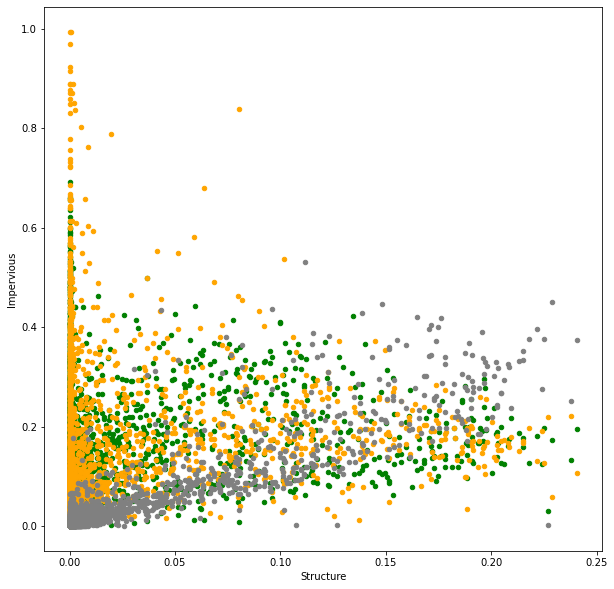

In [78]:
#boxesdf[value_cols].plot(x="Structure", y="Impervious", kind="scatter")
figsize= (10,10)
ax1 = boxesdf[value_cols].plot(x="Structure", y="Trees/Shrubs", kind="scatter", subplots=True, color="green", figsize=figsize)
ax2 = boxesdf[value_cols].plot(x="Structure", y="Barren", kind="scatter", subplots=True, ax=ax1, color="orange", figsize=figsize)
ax3 = boxesdf[value_cols].plot(x="Structure", y="Impervious", kind="scatter", subplots=True, ax=ax1, color="grey", figsize=figsize)
#ax4 = boxesdf.plot(x="Structure", y="Trees/Shrub", kind="scatter", subplots=True)
print(ax1==ax2==ax3)

In [121]:

print(vcs)
print(local_ratios_2015)


6502500
{1: 15253, 2: 1826400, 3: 150806, 4: 380108, 5: 643333, 6: 2265917, 7: 1220683}
{'Water': 0.0023457131872356785, 'Trees/Shrubs': 0.280876585928489, 'Irrigated': 0.0231920030757401, 'Desert': 0.0584556708958093, 'Barren': 0.0989362552864283, 'Impervious': 0.34846858900422917, 'Structure': 0.18772518262206844, 'Road': 0}


In [127]:
weights_2019 = {1: local_ratios_2015["Water"]*0.1,
                2: local_ratios_2015["Water"]*0.9,
                3: (local_ratios_2015["Barren"]) + (local_ratios_2015["Desert"]*0.6),
                4: (local_ratios_2015["Trees/Shrubs"] * 0.5) + (local_ratios_2015["Desert"]*0.3),
                5: (local_ratios_2015["Trees/Shrubs"] * 0.5) + (local_ratios_2015["Desert"]*0.1),
                6: local_ratios_2015["Irrigated"],
                7: local_ratios_2015["Road"] + (local_ratios_2015["Impervious"]*.8),
                8: local_ratios_2015["Impervious"] * 0.2,
                9: local_ratios_2015["Structure"]}
print(weights_2019)
for k, v in old_weights_2019.items():
    print(f"{values_2019[k]} = {v}")
    

{1: 0.00023457131872356787, 2: 0.0021111418685121107, 3: 0.13400965782391389, 4: 0.1579749942329873, 5: 0.14628386005382543, 6: 0.0231920030757401, 7: 0.27877487120338335, 8: 0.06969371780084584, 9: 0.18772518262206844}
PondLake = 0.00023457131872356787
Pool = 0.0021111418685121107
Barren = 0.13400965782391389
SparseVeg = 0.1579749942329873
DenseVeg = 0.14628386005382543
Irrigated = 0.0231920030757401
Asphault = 0.27877487120338335
Impervious = 0.06969371780084584
Structure = 0.18772518262206844


In [128]:
t = {1: 0.0001301748,
 2: 0.00030374119999999996,
 3: 0.1929180129375,
 4: 0.27926048605,
 5: 0.14124780635,
 6: 0.0478055011,
 7: 0.011059134684,
 8: 0.002646091136,
 9: 0.0093926619}

In [130]:
for k,v in weights_2019.items():
    diff = v - t[k]
    print(k, round(diff,7))

1 0.0001044
2 0.0018074
3 -0.0589084
4 -0.1212855
5 0.0050361
6 -0.0246135
7 0.2677157
8 0.0670476
9 0.1783325


In [ ]:
trainingSamples.loc[trainingSamples['LCClass'] == 'PondsLake', "Weight"] = ratios_2015["Water"] * 0.3
trainingSamples.loc[trainingSamples['LCClass'] == 'Pool', "Weight"] = ratios_2015["Water"] * 0.7
trainingSamples.loc[trainingSamples['LCClass'] == 'Barren', "Weight"] = ratios_2015["Barren"] + (ratios_2015["Desert"]*0.6)
trainingSamples.loc[trainingSamples['LCClass'] == 'SparseVeg', "Weight"] = (ratios_2015["Trees/Shrubs"] * 0.5) + (ratios_2015["Desert"]*0.3)
trainingSamples.loc[trainingSamples['LCClass'] == 'DenseVeg', "Weight"] = (ratios_2015["Trees/Shrubs"] * 0.5) + (ratios_2015["Desert"]*0.1)
trainingSamples.loc[trainingSamples['LCClass'] == 'IrrigatedLand', "Weight"] = ratios_2015["Irrigated"]
trainingSamples.loc[trainingSamples['LCClass'] == 'Asphault', "Weight"] = ratios_2015["Road"] + (ratios_2015["Impervious"]*.8)
trainingSamples.loc[trainingSamples['LCClass'] == 'Impervious', "Weight"] = ratios_2015["Impervious"] * 0.2
trainingSamples.loc[trainingSamples['LCClass'] == 'Structures', "Weight"] = ratios_2015["Structure"]